1. Exploratory Data Analysis (EDA) - Bitcoin Dataset
Project: CryptoGigel

Objective: Before running any ML models, we need to understand the data structure. This notebook covers data loading, cleaning, and initial visualization to spot trends, outliers, or missing values.

In [2]:
# 1. Environment Setup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries loaded.")

Libraries loaded.


2. Data Loading & Cleaning
Loading financial data isn't always straightforward. yfinance exports often have double headers or weird indexing. The block below handles:

Multi-Index Headers: Flattens the header if it detects the ticker symbol (e.g., 'BTC-USD') in the second row.

Date Parsing: Converts the date column to actual datetime objects for proper plotting.

Type Casting: Forces numerical columns to floats (prevents strings breaking the math later).

In [3]:
file_path = '../data/raw/bitcoin_raw.csv' 

try:
    df = pd.read_csv(file_path)
    
    # Sometimes the CSV saves with 2 header rows (Ticker + Column Name). 
    # If we detect "BTC-USD" or "Ticker" in the first row of data, reload with header=[0,1].
    first_row_vals = df.iloc[0].values.astype(str)
    if np.any(["Ticker" in val or "BTC-USD" in val for val in first_row_vals]):
        print("Detected multi-header format. Fixing...")
        df = pd.read_csv(file_path, header=[0, 1])
        df.columns = df.columns.droplevel(1) # Drop the 'BTC-USD' level, keep 'Close', 'Open' etc.

    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
    
    # Just in case some numbers came in as strings (e.g. "20,000")
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Drop any garbage rows created by the conversion
    df.dropna(inplace=True)

    print("Data successfully loaded and cleaned.")
    print(f"Dataset Shape: {df.shape} (Rows, Columns)")
    
    print("\nSample Data:")
    display(df.head())
    
    print("\nColumn Types:")
    print(df.dtypes)

except FileNotFoundError:
    print(f"CRITICAL ERROR: File not found at {file_path}. Did you run the download script?")
except Exception as e:
    print(f"An error occurred: {e}")

Detected multi-header format. Fixing...
Data successfully loaded and cleaned.
Dataset Shape: (1796, 5) (Rows, Columns)

Sample Data:


,Close,High,Low,Open,Volume
Date,,,,,
2020-01-01,7200.174316,7254.330566,7174.944336,7194.892090,18565664997
2020-01-02,6985.470215,7212.155273,6935.270020,7202.551270,20802083465
2020-01-03,7344.884277,7413.715332,6914.996094,6984.428711,28111481032
2020-01-04,7410.656738,7427.385742,7309.514160,7345.375488,18444271275
2020-01-05,7411.317383,7544.497070,7400.535645,7410.451660,19725074095



Column Types:
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object


3. Statistical Summary
Quick sanity check. We look at the mean, min, and max to ensure the data makes sense (e.g., no negative prices).

Count: Should match the number of rows (checking for hidden NaNs).

Std (Standard Deviation): Shows how volatile the asset is.

In [4]:
# Display summary statistics
print("Descriptive Statistics:")
display(df.describe().round(2)) # Rounding for readability

Descriptive Statistics:


,Close,High,Low,Open,Volume
count,1796.00,1796.00,1796.00,1796.00,1.796000e+03
mean,35248.66,35981.03,34398.49,35201.33,3.260587e+10
std,19651.94,20065.16,19164.89,19611.99,1.882074e+10
min,4970.79,5331.83,4106.98,5002.58,5.331173e+09
25%,19442.00,19884.52,19112.30,19430.27,2.048343e+10
50%,31230.78,31985.34,30241.27,31154.17,2.958483e+10
75%,49200.08,50488.06,47627.29,49202.96,3.962524e+10
max,98997.66,99655.50,97232.89,99006.74,3.509679e+11


4. Visual Analysis
A. Price History (Time Series)
Visualizing the entire timeline to identify major market cycles (Bull run vs Bear market). This confirms if our Date index is working correctly.

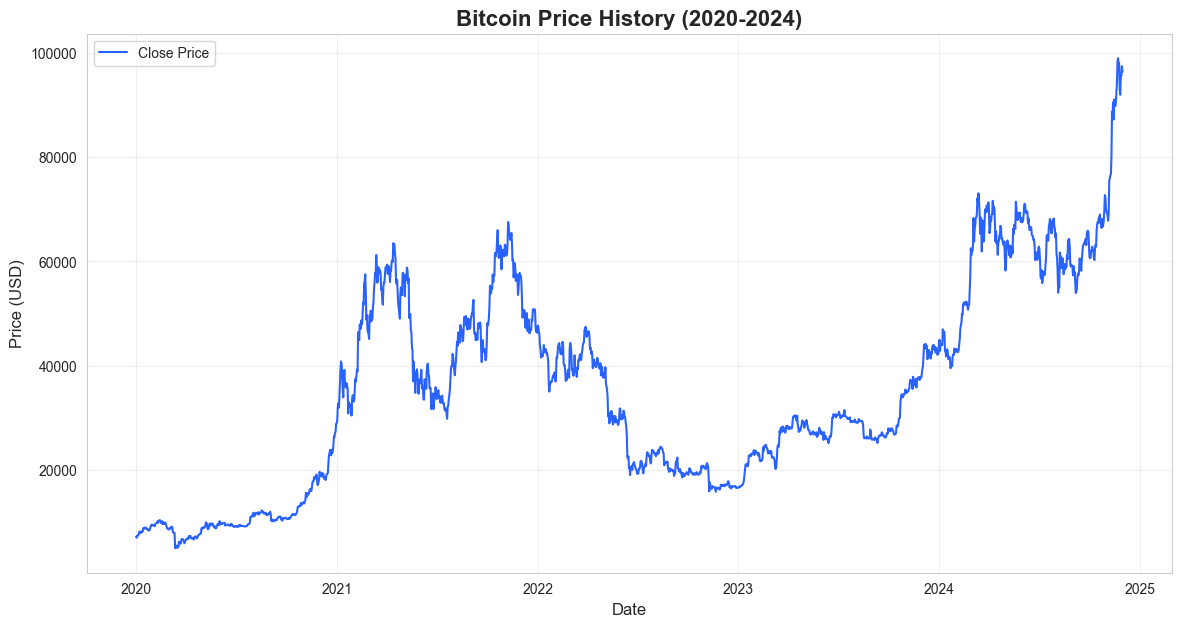

In [5]:
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Close'], label='Close Price', color='#2962FF', linewidth=1.5)

plt.title('Bitcoin Price History (2020-2024)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3) # Subtle grid
plt.show()

B. Distribution Analysis (Histogram)
Checking the distribution of prices.

Why? Most ML models (like Linear Regression) assume a Normal Distribution (Bell Curve).

Reality: Financial data is often "skewed". If the tail is long to the right, we have frequent high-price periods.

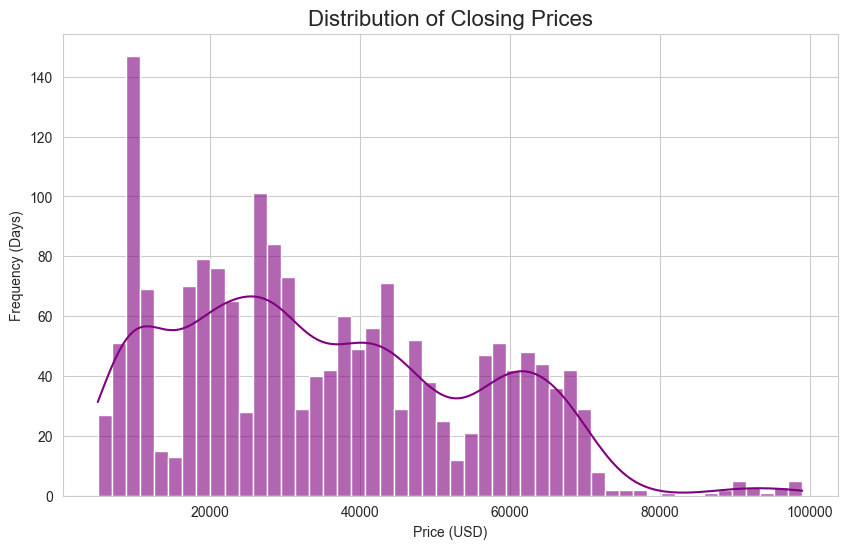

In [6]:
plt.figure(figsize=(10, 6))

# Plot histogram with Kernel Density Estimate (KDE) line
sns.histplot(df['Close'], bins=50, kde=True, color='purple', alpha=0.6)

plt.title('Distribution of Closing Prices', fontsize=16)
plt.xlabel('Price (USD)')
plt.ylabel('Frequency (Days)')
plt.show()

C. Feature Correlation (Heatmap)
We need to see which features move together.

Expectation: Open, High, Low, Close should be almost 100% correlated (dark red).

Target: We are looking for features that are not perfectly correlated, like Volume, as they might add new information to the model.

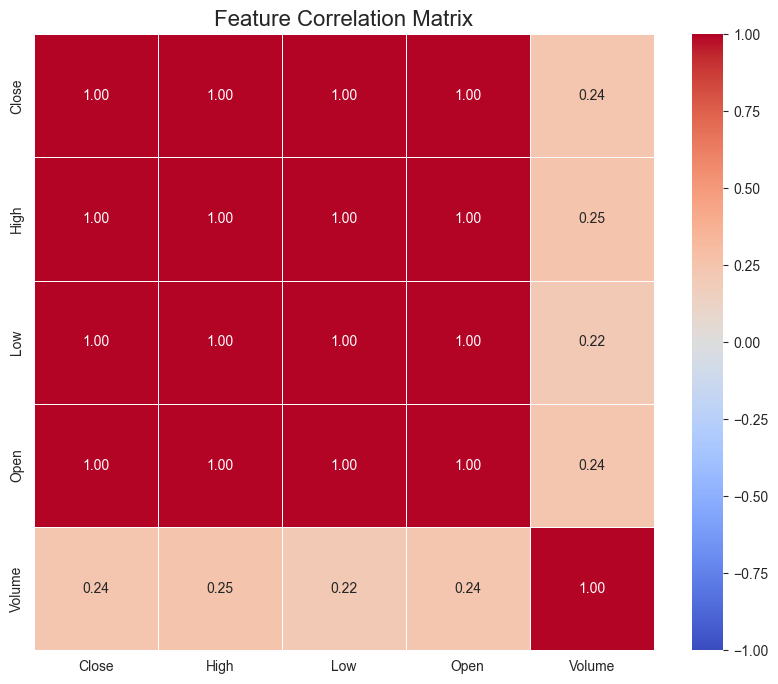

In [7]:
plt.figure(figsize=(10, 8))

# Calculate correlation only on numeric columns
corr_matrix = df.corr(numeric_only=True)

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix', fontsize=16)
plt.show()

D. Outlier Detection (Boxplots)
In traditional statistics, points outside the "whiskers" are errors.

Crypto Context: In Bitcoin, these "outliers" are usually real market events (crashes or pumps). We visualize them to understand the volatility, but we likely won't remove them as they contain critical market info.

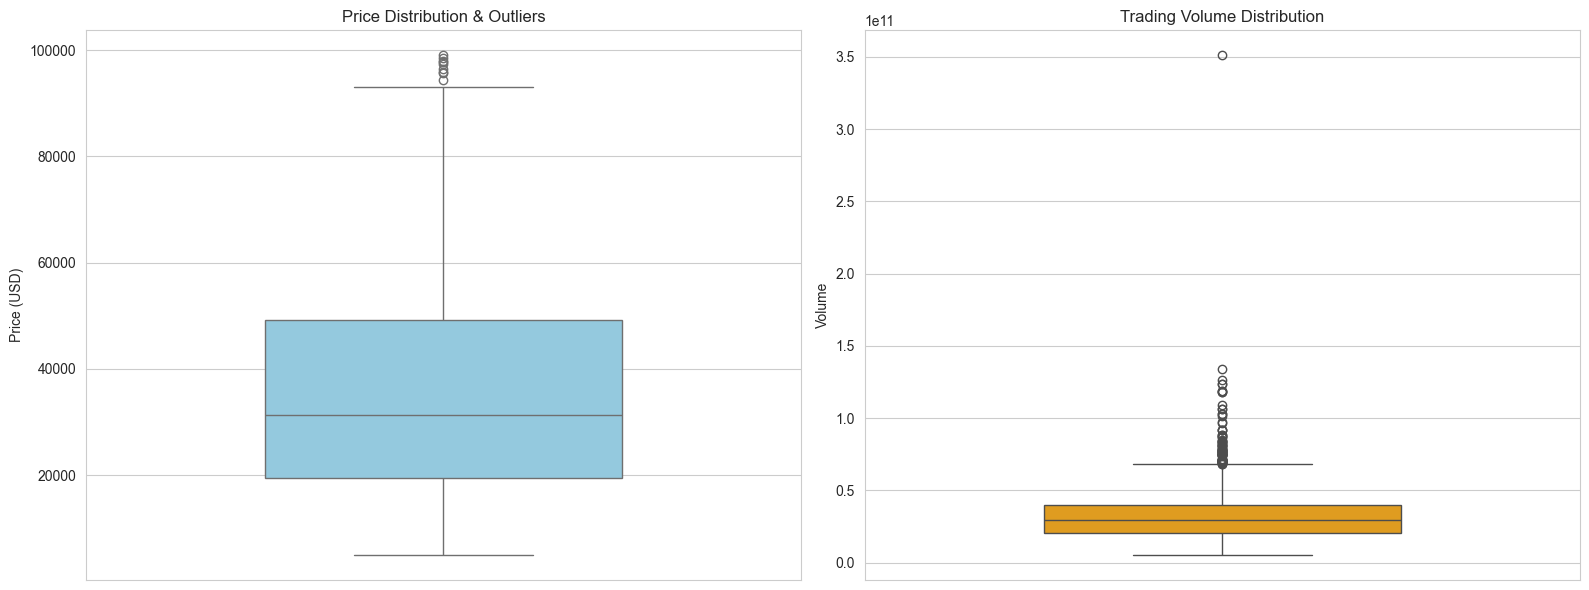

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# 1. Price Boxplot
sns.boxplot(y=df['Close'], ax=ax[0], color='skyblue', width=0.5)
ax[0].set_title('Price Distribution & Outliers')
ax[0].set_ylabel('Price (USD)')

# 2. Volume Boxplot
sns.boxplot(y=df['Volume'], ax=ax[1], color='orange', width=0.5)
ax[1].set_title('Trading Volume Distribution')
ax[1].set_ylabel('Volume')

plt.tight_layout()
plt.show()